# Purpose
This project **breaks down neural networks** into simple steps by walking through the process of building one from scratch using Python and NumPy. We'll be training our network on the MNIST Dataset, a collection of 70,000 handwritten digit images (0-9), each 28x28 pixels in size. By following this guide, you'll not only gain a solid understanding of how neural networks work but also train a model that can classify digits with over 90% accuracy.

## Introduction to Neural Networks
Neural networks are computational models inspired by the structure of the human brain. These models consist of layers of neurons that process data in a hierarchical manner, making them ideal for recognizing patterns in complex data like images or speech.

For this project, we'll focus on a **feedforward neural network**, which is ideal for beginners. Our network will have the following structure:

* Input Layer: 784 neurons (28x28 pixels of each MNIST image).
* Hidden Layer 1: 32 neurons.
* Hidden Layer 2: 16 neurons.
* Output Layer: 10 neurons (representing digits 0-9).

This setup is designed for **multi-class classification**, where the network predicts the most probable class (digit) for a given input image.

## Step 1: Load the dataset

In this step, we'll retrieve the MNIST dataset, extract the features (image data) and labels (digit values), split the data into training and testing sets, and visualize some sample images.

---

### 1.1 Download the Dataset and Define the Network Architecture
We'll use the `openml` library to fetch the MNIST dataset. This library simplifies the process of accessing datasets, allowing us to focus more on the neural network itself.

Once we have the dataset, we'll define the network architecture, using variables to represent key dimensions such as the number of neurons in each layer. These variables will be referenced throughout the program, keeping our networks dimensions uniform.

In [1]:
import openml
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Download MNIST dataset from OpenML
mnist = openml.datasets.get_dataset(554)    # ID for MNIST

# Define network architecture
input_size = 28 * 28         # 784 input neurons
hidden_sizes = [32, 16]      # Two hidden layers with 32 and 16 neurons
output_size = 10             # 10 output neurons for digits 0-9
layer_dims = [input_size] + hidden_sizes + [output_size]    # Total network dimensions

### 1.2 Extract Data and Labels

After downloading, we'll extract the feature data (`x`) and labels (`y`):

* x: Contains the pixel data for each image, reshaped into a 784-dimensional vector (28x28 pixels).
* y: Contains the integer labels (0-9) corresponding to each image.

To prepare the data for training, we'll normalize the pixel values (which originally range from 0 to 255) to values between 0 and 1. This normalization step helps the model converge more quickly during training.

In [2]:
# Extract data and labels from dataset
x, y, _, _ = mnist.get_data(target=mnist.default_target_attribute)

# Normalize pixel values to range [0, 1] and reshape data
x = x.to_numpy().reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y.astype(int)

### 1.3 Split Data into Training and Testing Sets

To evaluate our model's performance, we'll divide the dataset into

* Training Set: 60,000 images used to train the neural network.
* Testing Set: 10,000 images used to evaluate the model's performance after training.

It's essential to keep these sets separate to avoid overfitting, ensuring that the model can generalize well to unseen data.

In [3]:
# Split data into training and testing sets
x_train, x_test = x[:60000].T, x[60000:].T  # Transpose to shape (784, number_of_samples)
y_train, y_test = y[:60000], y[60000:]

# Print shapes of data and labels
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x shape: (70000, 784)
y shape: (70000,)
x_train shape: (784, 60000), x_test shape: (784, 10000)
y_train shape: (60000,), y_test shape: (10000,)


### 1.4 Visualizing Sample Space

Visualizing a subset of the dataset helps in understanding the data we're working with. We'll display 25 random images from the training set along with their labels.

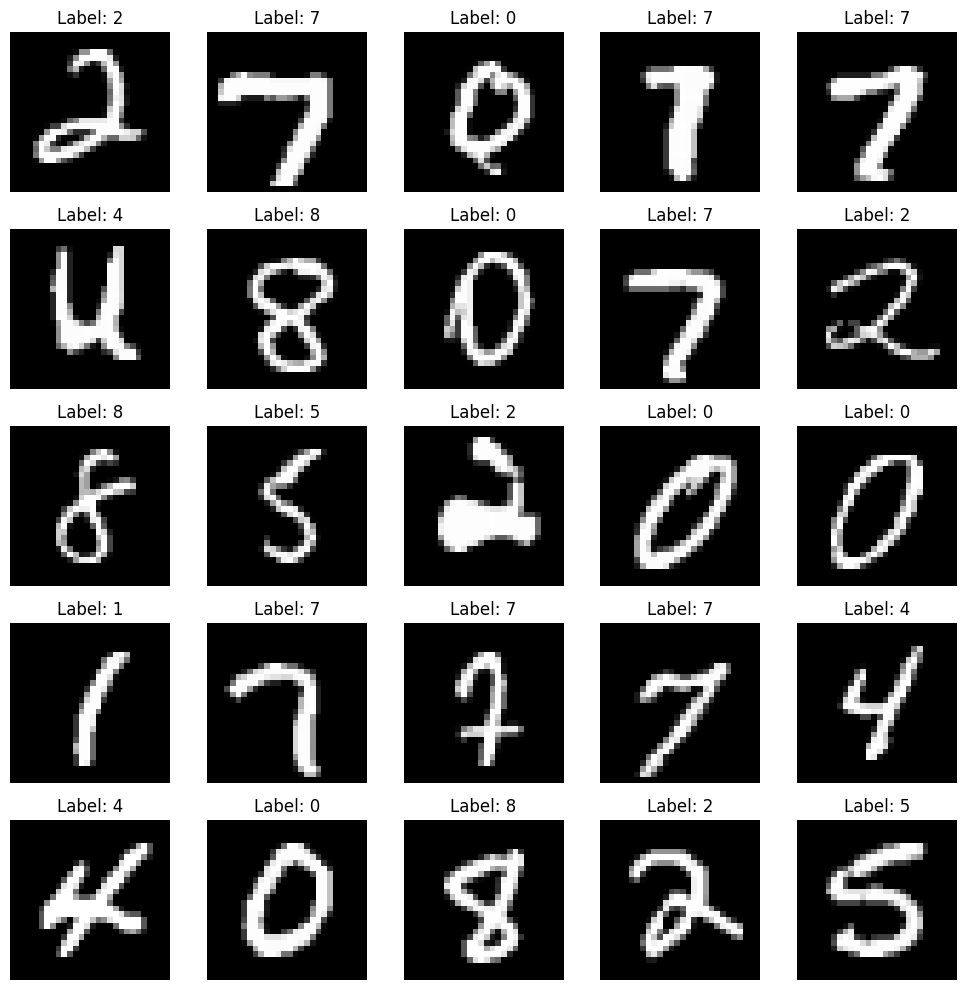

In [4]:
# Function to visualize sample images
def visualize_samples(x, y, num_samples=25):

    plt.figure(figsize=(10,10))
    indices = np.random.choice(x.shape[1], num_samples, replace=False)

    for i, idx in enumerate(indices):

        image = x[:, idx].reshape(28, 28)
        label = y[idx]

        plt.subplot(5, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize sample images from the training set
visualize_samples(x_train, y_train)

### 1.5 Neural Network Parameters

This function will return the total number of trainable parameters in the network. Each parameter can be thought of as a knob that we'll fine-tune throughout training.

In [5]:
def total_parameters(layer_dims):
    """
    Parameters:
    layer_dims (list): List containing the dimensions of each layer in the network.
    
    Returns:
    int: Total number of parameters (weights + biases).
    """
    total_params = 0
    
    # Loop over each layer (except input) and calculate parameters
    for i in range(1, len(layer_dims)):

        weight_params = layer_dims[i] * layer_dims[i - 1]  # Weights
        bias_params = layer_dims[i]                        # Biases
        total_params += weight_params + bias_params
    
    return total_params

# Compute total parameters
total_params = total_parameters(layer_dims)
print(f"Total parameters in the network: {total_params}")

Total parameters in the network: 25818


## Step 2 Weights and Biases

Neural networks learn patterns by adjusting weights and biases. Proper initialization of these parameters is critical to ensure efficient learning and faster convergence.

* Weights: These define the strength of the connections between neurons and are updated during training.
* Biases: These provide each neuron with a trainable offset, allowing the model to fit data more effectively.

In this step, we'll initialize weights using He initialization (which helps maintain stable activations) and set the biases to zeros.

---

### 2.1 Initializing Weights and Biases

To initialize the weights and biases, we’ll follow these steps:

Weights: We'll use He initialization, which samples weights from a normal distribution centered at 0, with a specific variance. This helps maintain the variance of activations throughout the network and prevents issues like vanishing or exploding gradients — especially in networks with ReLU activation functions.

Mathematically, the weights for layer $ i $ are sampled as:

$$ W^{[i]} \sim \mathcal{N}(0, \sqrt{\frac{2}{n^{[i - 1]}}}) $$

* $ n^{[i - 1]} $: the number of neurons in the previous layer.
* $ \mathcal{N}(0, \sigma^2) $: normal (Gaussian) distribution with mean 0 and variance $ \sigma^2 $

Biases: These are initialized to zeros. Since they do not influence the variance of activations and are adjusted during training, starting them at zero is standard practice.

In [6]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- Python list containing the dimensions of each layer in the network.

    Returns:
    weights -- List of weight matrices.
    biases -- List of bias vectors.
    """
    
    # Lists to store weights and biases for each layer
    weights = []
    biases = []
    
    # Loop over the layers to initialize weights and biases
    for i in range(1, len(layer_dims)):

        # He initialization for weights
        w = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(2. / layer_dims[i - 1])
        
        # Initialize biases to zeros
        b = np.zeros((layer_dims[i], 1))
        
        weights.append(w)
        biases.append(b)
    
    return weights, biases

weights, biases = initialize_parameters(layer_dims)

for i in range(len(weights)):
    print(f"Weight matrix for layer {i + 1}: {weights[i].shape}")
    print(f"Bias vector for layer {i + 1}: {biases[i].shape}\n")

Weight matrix for layer 1: (32, 784)
Bias vector for layer 1: (32, 1)

Weight matrix for layer 2: (16, 32)
Bias vector for layer 2: (16, 1)

Weight matrix for layer 3: (10, 16)
Bias vector for layer 3: (10, 1)



### Step 2.2 Visualizing the Neural Network

Understanding the architecture visually can provide clarity on how data flows through the network. We'll create a simplified diagram of our neural network.

* Input Layer: Represents the 784 input neurons (pixels). Due to space constraints, only a subset is displayed with an ellipsis (...) indicating the skipped neurons.
* Hidden Layers: Contain 32 and 16 neurons, respectively, that process the inputs.
* Output Layer: Comprises 10 neurons corresponding to the digits 0-9.

Connections: Lines between neurons signify the weighted connections. Faint lines indicate a fully connected network.

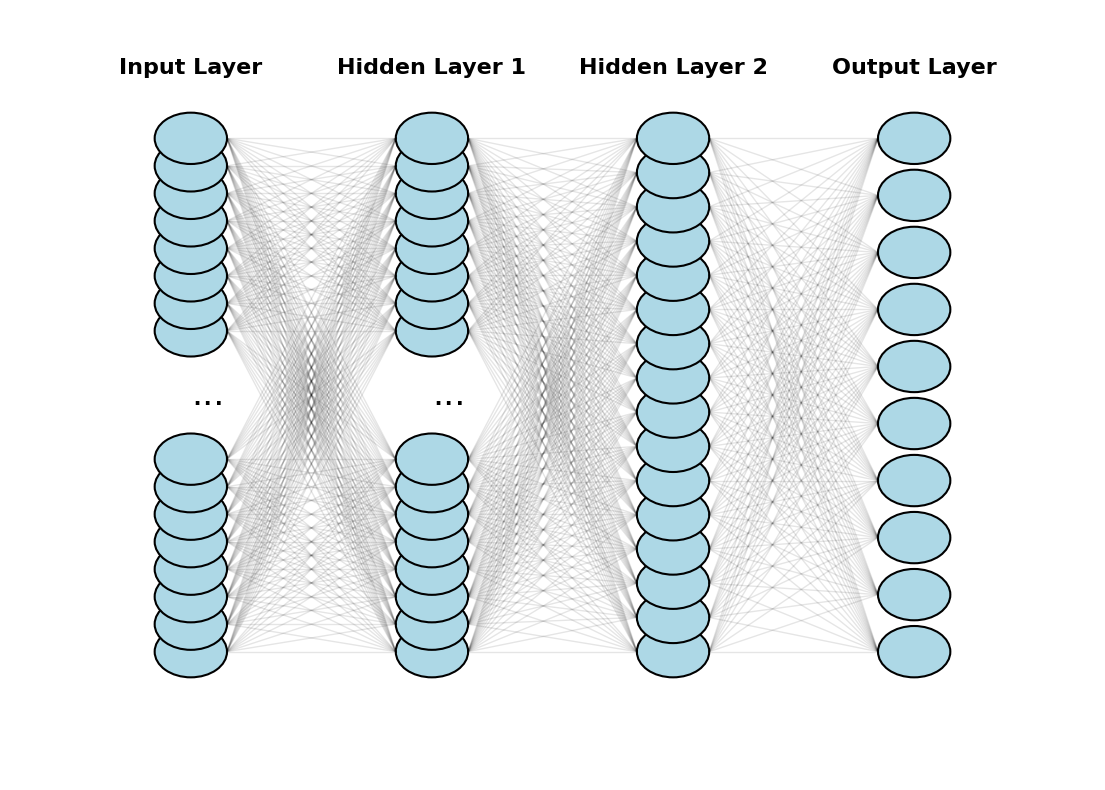

In [7]:
def draw_neural_network(layer_dims, max_display=16):
    """
    Arguments:
    layer_dims -- List of integers representing the number of neurons in each layer.
    max_display -- Maximum number of neurons to display per layer for visualization.
    """

    total_layers = len(layer_dims)
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis('off')

    neuron_size = 0.4  # Circle size for each neuron
    neuron_color = 'lightblue'
    
    # Function to generate neuron positions for a layer
    def generate_layer_positions(x_position, n_neurons):
        if n_neurons > max_display:

            displayed_neurons = max_display // 2
            positions = np.linspace(2, 5, displayed_neurons).tolist() + \
                        np.linspace(7, 10, displayed_neurons).tolist()
        else:

            positions = np.linspace(2, 10, n_neurons)

        return [(x_position, y) for y in positions]
    
    layers = []
    x_positions = np.linspace(2, 10, total_layers)

    for idx, n_neurons in enumerate(layer_dims):

        layer = generate_layer_positions(x_positions[idx], n_neurons)
        layers.append(layer)
    
    # Draw neurons
    for layer in layers:

        for neuron in layer:

            circle = patches.Circle(neuron, neuron_size, fill=True, color=neuron_color, ec='k', lw=1.5)
            ax.add_patch(circle)
    
    # Draw connections
    for i in range(len(layers) -1):

        layer1 = layers[i]
        layer2 = layers[i+1]

        for n1 in layer1:

            for n2 in layer2:

                ax.plot([n1[0]+0.4, n2[0]-0.4], [n1[1], n2[1]], 'k-', alpha=0.1, lw=1)
    
    # Add '...' to indicate skipped neurons
    for idx, layer in enumerate(layers):

        n_neurons = layer_dims[idx]

        if n_neurons > max_display:

            ax.text(x_positions[idx], 6, '...', fontsize=25, verticalalignment='center', color='black')
    
    # Layer labels
    layer_names = ['Input Layer'] + [f'Hidden Layer {i+1}' for i in range(len(layer_dims)-2)] + ['Output Layer']

    for idx, name in enumerate(layer_names):
        
        ax.text(x_positions[idx], 11, name, horizontalalignment='center', fontsize=16, fontweight='bold')
    
    plt.show()

# Visualize the neural network architecture
draw_neural_network(layer_dims)


## Step 3: Activation and Loss Functions

Activation functions introduce non-linearity into the network, enabling it to learn complex patterns. The loss function measures how well the neural network is performing by comparing its prediction on a sample with the true label of the sample.

* We'll cover 3 different types of activation functions and will end up using Tanh (the last one covered).

---

### 3.1 Sigmoid Activation Function

The sigmoid activation function is typically the first function learned to introduce non-linearity into neural networks. It maps input values into a range between 0 and 1, making it useful in cases where we need probabilities.

The mathematical formula for input $ z $ looks like:

$$\sigma (z) = \frac{1}{1 + e^{-z}}$$

* $ z $: The input to the function, which can be any real-valued number.

**Function Visualization**

* S-shape Curve: The sigmoid function smoothly maps any input value to a value between 0 and 1.
* Threshold Behavior: Values around 0 are mapped to 0.5, while large positive or negative inputs approach 1 or 0, respectively.

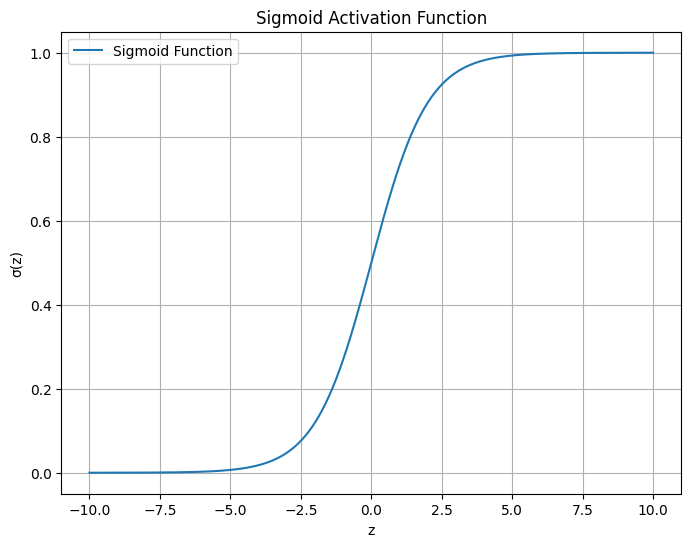

In [8]:
def sigmoid(z):
    """
    Arguments:
    z -- numpy array of any shape, input values (logits) to the sigmoid function

    Returns:
    s -- numpy array of the same shape as z, containing the sigmoid of each element in z
    """
    s = 1 / (1 + np.exp(-z))

    return s

# Generate input values for visualization
z = np.linspace(-10, 10, 1000)
sigmoid_z = sigmoid(z)

# Plot the sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_z, label='Sigmoid Function')
plt.title('Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.legend()
plt.show()

### 3.2 Sigmoid Derivative

To perform backpropagation, which allows the network to learn by adjusting weights and biases, we need the derivative of the activation function. The derivative of the sigmoid function helps compute the gradients during this process.

The derivative of the sigmoid is given by:

$$\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z)) $$

* $ \sigma(z) $: The output of the sigmoid function, which will always be between 0 and 1.

**Function Visualization**

* Peak at z = 0: The derivative is largest at 0, where the sigmoid is steepest.
* Symmetric Decay: The derivative quickly approaches 0 as z becomes either large or small, meaning gradients vanish for extreme values (this is bad).

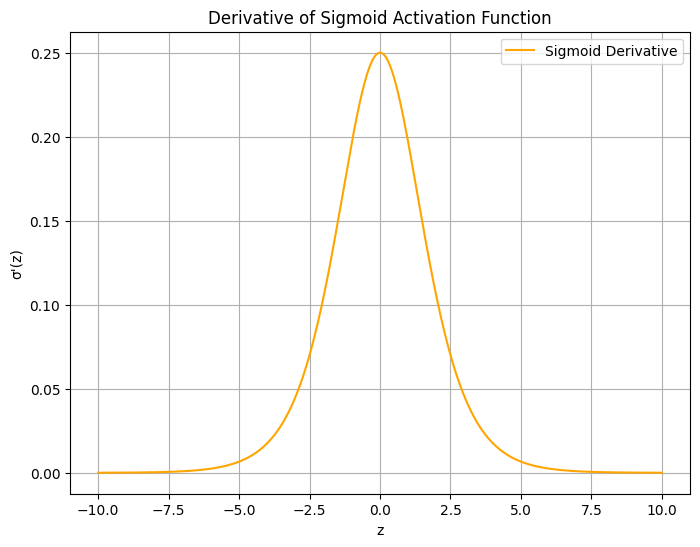

In [9]:
def sigmoid_derivative(z):
    """
    Arguments:
    z -- numpy array of any shape, input values (logits) to the sigmoid function

    Returns:
    ds -- numpy array of the same shape as z, containing the derivative of the sigmoid function for each element in z
    """
    s = sigmoid(z)
    ds = s * (1 - s)
    
    return ds


# Compute derivative for visualization
sigmoid_derivative_z = sigmoid_derivative(z)

# Plot the derivative of the sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_derivative_z, label='Sigmoid Derivative', color='orange')
plt.title('Derivative of Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel("σ'(z)")
plt.grid(True)
plt.legend()
plt.show()


### 3.3 ReLU Activation Function

The **Rectified Linear Unit (ReLU)** is one of the most widely used activation functions in hidden layers due to its simplicity and efficiency. It outputs the input directly if it is positive; otherwise, it outputs zero. Since this function is simpler than the others we're looking at, it is often chosen for deep neural networks to speed up training.

The ReLU function can be represented as:

$$ \text{ReLU}(z) = \text{max}(0, z) $$

* $ z $: Input to the function, which can be any real-valued number.

**Key Properties:**

* Zero for Negative Inputs: ReLU outputs zero for all negative values of $ z $.
* Linear for Positive Inputs: ReLU passes positive inputs unchanged, making it computationally efficient.

**Advantages of ReLU:**

* Efficiency: It involves simple computations compared to the Sigmoid function.
* Avoids Vanishing Gradient: Gradients remain large for positive inputs, helping avoid the vanishing gradient problem.

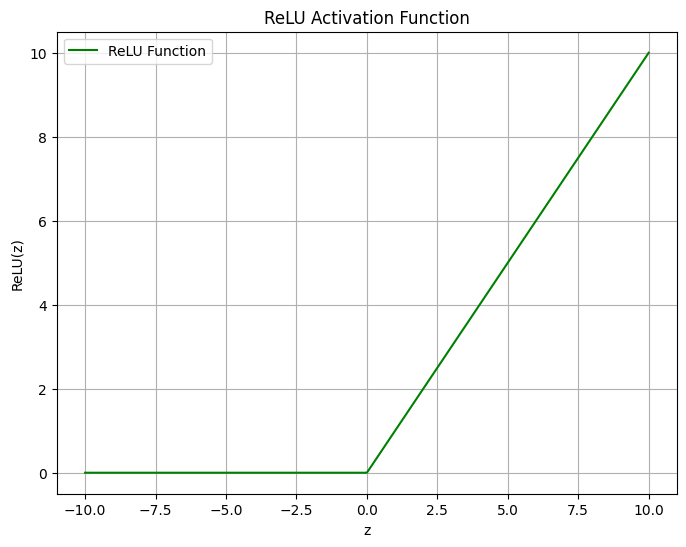

In [10]:
def relu(z):
    """
    Arguments:
    z -- numpy array of any shape, input values (logits) to the ReLU function

    Returns:
    r -- numpy array of the same shape as z, containing the ReLU of each element in z (max(0, z))
    """
    r = np.maximum(0, z)
    
    return r


# Generate input values for visualization
z = np.linspace(-10, 10, 1000)
relu_z = relu(z)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(z, relu_z, label='ReLU Function', color='green')
plt.title('ReLU Activation Function')
plt.xlabel('z')
plt.ylabel('ReLU(z)')
plt.grid(True)
plt.legend()
plt.show()


#### 3.4 ReLU Derivative

The derivative of ReLU is essential for backpropagation, allowing the network to adjust the weights and biases during training.

Due to the simplicity of the ReLU function, the derivative is just:

$$ \text{ReLU}'(z) = 
\begin{cases}
    1 & \text{if } z > 0 \\
    0 & \text{otherwise}
\end{cases} $$

**Function Visualization**

* Derivative is 1: When $ z > 0 $, the gradient is 1, which ensures that the gradient does not vanish for positive values.
* Derivative is 0: For negative values of z, the derivative is 0, meaning no gradient is passed for negative values.

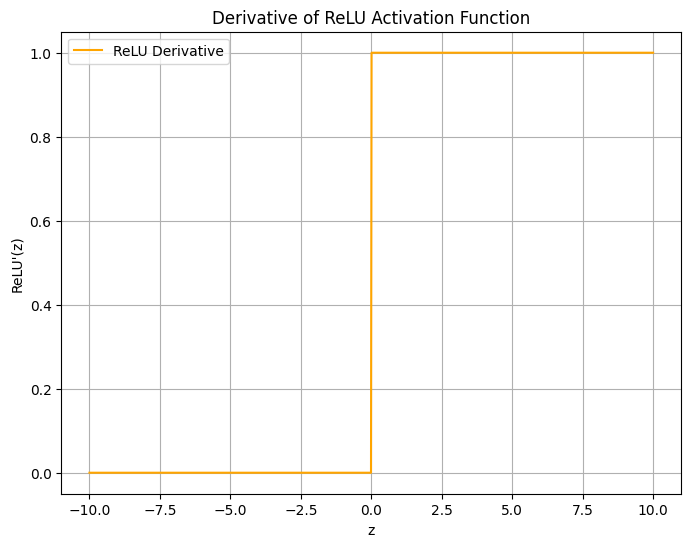

In [11]:
def relu_derivative(z):
    """
    Arguments:
    z -- numpy array of any shape, input values (logits) to the ReLU function

    Returns:
    dr -- numpy array of the same shape as z, containing the derivative of the ReLU function for each element in z
           (1 for z > 0, 0 otherwise)
    """
    dr = (z > 0).astype(float)
    return dr

# Compute the derivative for visualization
relu_derivative_z = relu_derivative(z)

# Plot the derivative of ReLU
plt.figure(figsize=(8, 6))
plt.plot(z, relu_derivative_z, label='ReLU Derivative', color='orange')
plt.title('Derivative of ReLU Activation Function')
plt.xlabel('z')
plt.ylabel("ReLU'(z)")
plt.grid(True)
plt.legend()
plt.show()


### 3.5 Tanh Activation Function

The hyperbolic tangent (tanh) activation function is similar in shape to the sigmoid but maps input values to a range between -1 and 1, instead of 0 and 1. This zero-centered output often leads to better convergence in practice compared to sigmoid, especially for hidden layers.

The mathematical formula for input $ z $ looks like:

$$tanh (z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

* $ z $: The input to the function, which can be any real-valued number.

**Function Visualization**

* S-shaped Curve (Zero-Centered): Outputs range from -1 to 1, which helps balance positive and negative signals during training.
* Saturation: Like sigmoid, tanh saturates for very large or small inputs, which can still cause vanishing gradients.

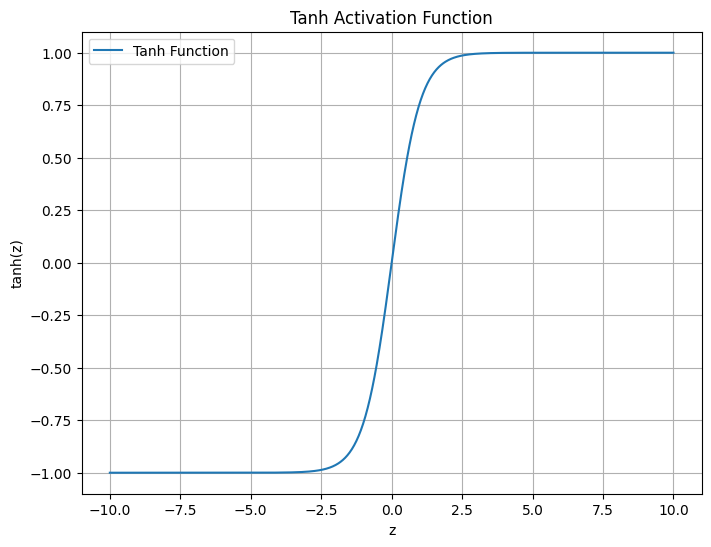

In [12]:
def tanh(z):
    """
    Arguments:
    z -- numpy array of any shape, input values to the tanh function

    Returns:
    t -- numpy array of the same shape as z, containing the tanh of each element in z
    """
    t = np.tanh(z)
    return t

# Generate input values for visualization
z = np.linspace(-10, 10, 1000)
tanh_z = tanh(z)

# Plot the tanh function
plt.figure(figsize=(8, 6))
plt.plot(z, tanh_z, label='Tanh Function')
plt.title('Tanh Activation Function')
plt.xlabel('z')
plt.ylabel('tanh(z)')
plt.grid(True)
plt.legend()
plt.show()

### 3.6 Tanh Derivative

As with other activation functions, we need the derivative of tanh for backpropagation. The derivative is efficient to compute and helps guide learning by showing how much a change in input affects the output.

The derivative of tanh is:

$$tanh' (z) = 1 - tanh^2(z)$$

* $ \tanh(z) $: Thoe output of the tanh function, between -1 and 1

**Function Visualization**

* Peak at z = 0: The derivative is largest near 0, where the tanh curve is steepest.
* Vanishing Gradient: As inputs become large or small, the derivative approaches 0, similar to sigmoid, which can slow learning.

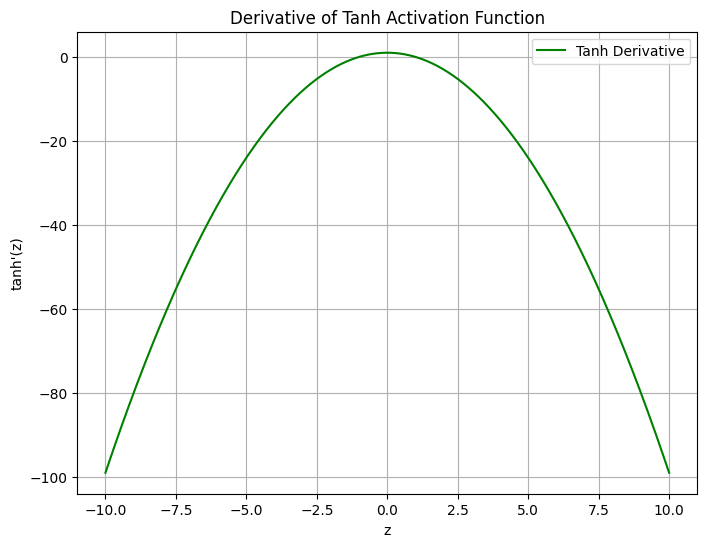

In [13]:
def tanh_derivative(z):
    """
    Arguments:
    z -- numpy array of any shape, input values to the tanh function

    Returns:
    dt -- numpy array of the same shape as z, containing the derivative of tanh for each element in z
    """
    dt = 1 - np.square(z)
    return dt

# Compute derivative for visualization
tanh_derivative_z = tanh_derivative(z)

# Plot the derivative of the tanh function
plt.figure(figsize=(8, 6))
plt.plot(z, tanh_derivative_z, label='Tanh Derivative', color='green')
plt.title('Derivative of Tanh Activation Function')
plt.xlabel('z')
plt.ylabel("tanh'(z)")
plt.grid(True)
plt.legend()
plt.show()

### 3.7 Softmax Activation Function

The softmax function is commonly used in the output layer for multi-class classification tasks. It converts a vector of raw scores (logits) into a probability distribution, where each output represents teh probability of the input belonging to that specific class.

* Probability Distribution: The output values are between 0 and 1 and all sum to 1 across classes.
* Exponentiation: Larger input scores result in proportionally larger probabilities due to the exponential function, which amplifies differences.

The formula for the Softmax function for a vector $ \mathbf{z} = [z_1, z_2, \dots, z_K] $ is:

$$ \text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{i = 1}^Ke^{z_i}} $$

* $ z_k $: The input (logit) corresponding to class $ k $.
* $ K $: The total number of classes
* $ \sum_{i = 1}^Ke^{z_i} $: The sum of exponentiated logits for all classes. This ensures that the Softmax output for each class sums to 1, turning the logits into probabilities.

**Function Behavior**

* Amplifies Differences: A small difference in logits can result in a large difference in probabilities.
* Sensitive to Scale: Very large input values can lead to numerical instability, which is why logits are often normalized before applying Softmax.

Sum of probabilities: 1.0


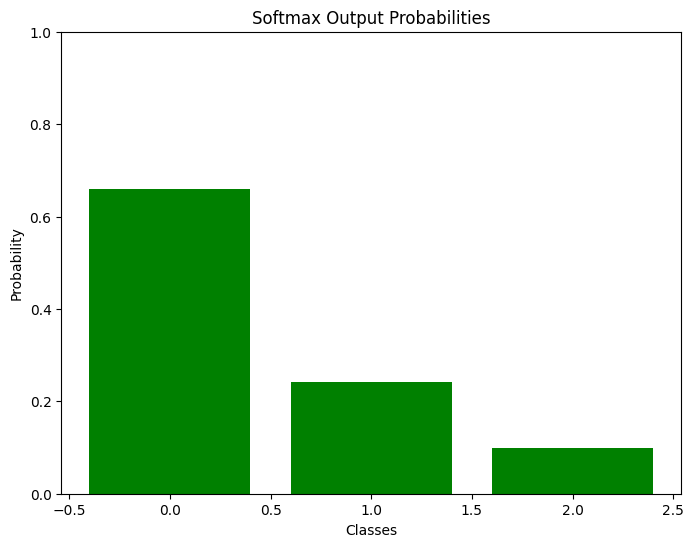

In [14]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Stability trick to prevent overflow
    return exp_z / exp_z.sum(axis=0, keepdims=True)

# Visualize softmax output for sample scores
def plot_softmax(scores):
    scores = np.array(scores)
    probabilities = softmax(scores.reshape(-1, 1)).flatten()
    print("Sum of probabilities:", np.sum(probabilities))

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(scores)), probabilities, color='green')
    plt.title('Softmax Output Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

# Example usage: Visualizing softmax output for sample scores
sample_scores = [2.0, 1.0, 0.1]
plot_softmax(sample_scores)

### 3.6 Cross-Entropy Loss

The cross-entropy loss function is used to measure how well the predicted probabilities from the neural network match the actual labels for multi-class classification tasks.

The formula for cross-entropy loss is:

$$ L = - \frac{1}{m}\sum_{i = 1}^m \log (\hat{A}_{y^{(i)}, i}) $$

* $m$: The number of training samples.
* $y^{(i)}$: The correct class label for the $i$-th example.
* $\hat{A}_{y^{(i)}, i}$: The predicted probability of the correct class for the $i$-th example, obtained from the softmax output (final layer).

In simpler terms, this formula picks out the model’s predicted probability for the correct class for each example and penalizes it if that probability is low.

In [15]:
def compute_loss(aL, y):
    """
    Arguments:
    aL -- numpy array of shape (num_classes, m), softmax probabilities for each class
    y -- numpy array of shape (m,), true class indices for each example

    Returns:
    loss -- scalar, the average cross-entropy loss
    """
    m = y.shape[0]  # Number of examples

    # Avoid log(0) by clipping values
    epsilon = 1e-15
    aL_clipped = np.clip(aL, epsilon, 1 - epsilon)

    # Extract the predicted probabilities for the correct classes
    correct_log_probs = -np.log(aL_clipped[y, np.arange(m)])

    # Compute average loss
    loss = np.mean(correct_log_probs)

    return loss

## Step 4: Forward and Backward Propagation

Propagation in neural networks refers to how data moves through the network and how the parameters (weights and biases) are updated to improve predictions during training.

---

### 4.1 Forward Propagation

Forward propagation refers to the process of feeding the input data into the network and computing the activations layer by layer until we get the final output (predictions). The network performs two steps for each layer:

1. Linear Step: Compute the weighted sum of the input plus bias:
$$ Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]} $$

* $ Z^{[l]} $: The linear input to the activation function at layer $ l $.
* $ W^{[l]} $: The weight matrix of layer $ l $.
* $ A^{[l-1]} $: The activations from the previous layer (or input data for the first layer).
* $ b^{[l]} $: The bias vector for layer $ l $.

2. Activation Step: Apply an activation function to compute the output of the current layer:

* For hidden layers: $ A^{[l]} = \text{Tanh}(Z^{[l]}) $
* For the output layer: $ A^{[L]} = \text{Softmax}(Z^{[L]}) $

Where $ L $ is the index of the final layer.

In [16]:
def forward_propagation(x, weights, biases):
    """
    Arguments:
    x -- numpy array of shape (input_size, m), input data (e.g., images from MNIST)
    weights -- list of numpy arrays, each representing the weight matrix for a layer
    biases -- list of numpy arrays, each representing the bias vector for a layer

    Returns:
    output -- numpy array of shape (output_size, m), the predicted probabilities (output of softmax)
    cache -- dictionary containing 'activations' and 'zs', intermediate results for backpropagation
    """
    
    activations = [x]  # List to store activations, starting with input layer
    zs = []  # List to store linear step results (Z values)
    
    # Forward propagation through hidden layers
    for i in range(len(weights) - 1):

        # Linear step: Z = W * A + b
        z = np.dot(weights[i], activations[-1]) + biases[i]
        zs.append(z)  # Store Z

        # Activation step using Tanh for hidden layers
        a = tanh(z)
        activations.append(a)
    
    # Forward propagation through the output layer
    z = np.dot(weights[-1], activations[-1]) + biases[-1]  # Linear step for output layer
    zs.append(z)  # Store Z for output layer

    # Activation step using Softmax for the output layer
    a = softmax(z)
    activations.append(a)

    # Store activations and Z values in a cache for later use in backpropagation
    cache = {
        'activations': activations,
        'zs': zs
    }
    
    return activations[-1], cache  # Return the output (final activation) and the cache


#### 4.1.1 Visualizing Forward Propagation

To gain a better understanding of how data flows through the network, we'll visualize the activations at each layer for a single input image. This will help us see how the input is transformed as it moves through the network.

* Input Image: Displays the original image from the test set.
* Layer Activations: Shows the activations of neurons in each hidden layer.
* Output Probabilities: Bar chart showing the probabilities for each class (digit 0-9).

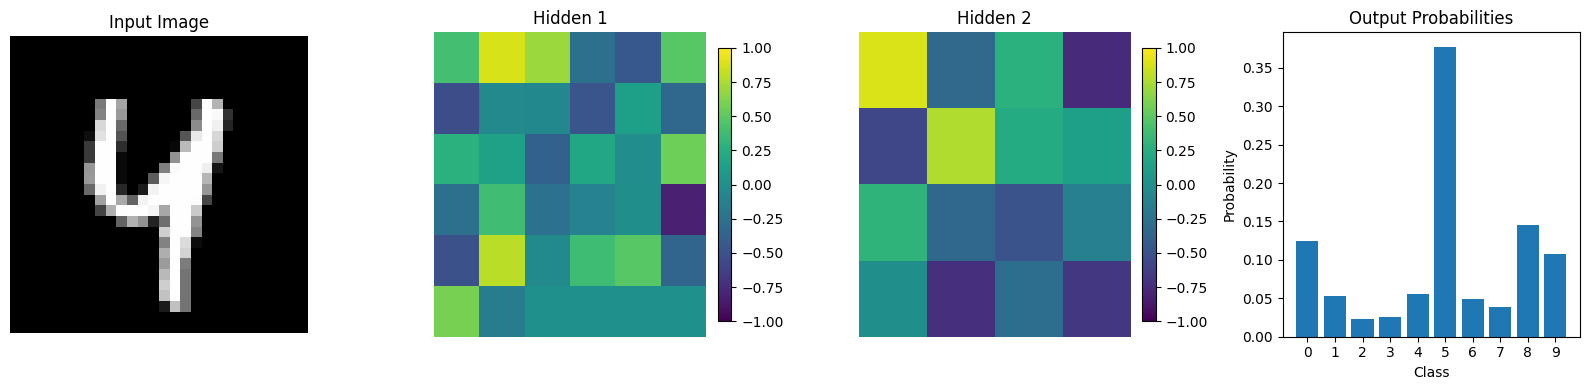

This data isn't valuable because the network isn't trained yet!


In [17]:
def visualize_forward_propagation(x_sample, weights, biases):
    """
    Visualizes forward propagation for a single input sample with tanh activations.
    
    Arguments:
    x_sample -- numpy array of shape (input_size, 1), a single MNIST image
    weights -- list of numpy arrays, the weight matrices
    biases -- list of numpy arrays, the bias vectors
    """
    # Forward pass
    _, cache = forward_propagation(x_sample, weights, biases)
    activations = cache['activations']

    num_layers = len(activations)
    fig, axes = plt.subplots(1, num_layers, figsize=(16, 4))
    layer_titles = ['Input'] + [f'Hidden {i}' for i in range(1, num_layers - 1)] + ['Output']

    for idx, ax in enumerate(axes):
        act = activations[idx]

        if idx == 0:
            # Input image
            ax.imshow(act.reshape(28, 28), cmap='gray')
            ax.set_title('Input Image')
            ax.axis('off')

        elif idx == num_layers - 1:
            # Output: bar chart
            ax.bar(range(act.shape[0]), act.flatten())
            ax.set_xticks(range(act.shape[0]))
            ax.set_title('Output Probabilities')
            ax.set_xlabel('Class')
            ax.set_ylabel('Probability')

        else:
            # Hidden layers: tanh activations, shown with colorbar
            neurons = act.shape[0]
            side = int(np.ceil(np.sqrt(neurons)))
            grid = np.zeros((side * side,))
            grid[:neurons] = act.flatten()

            img = ax.imshow(grid.reshape(side, side), cmap='viridis', aspect='auto', vmin=-1, vmax=1)
            ax.set_title(layer_titles[idx])
            ax.axis('off')

            # Add colorbar for activation intensity (-1 to 1 for tanh)
            fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

weights, biases = initialize_parameters(layer_dims)

sample_index = 42

# Convert y_test to a NumPy array
if not isinstance(y_test, np.ndarray):
    
    y_test = y_test.to_numpy()

# Select a sample from the test set
x_sample = x_test[:, sample_index].reshape(-1, 1)  # Reshape the input sample to (784, 1)
y_sample = y_test[sample_index]

# Visualize forward propagation for the selected sample
visualize_forward_propagation(x_sample, weights, biases)

# Since the network is not yet trained, the output probabilities are not meaningful
print("This data isn't valuable because the network isn't trained yet!")

### 4.2 Backward Propagation

Backward propagation is the learning engine of a neural network. It computes how much each parameter (weight or bias) contributed to the overall error, and adjusts them to reduce that error. This process involves applying the chain rule layer-by-layer in reverse — from output back to input.

1. Output Layer Error
For the final layer (using softmax activation with cross-entropy loss), the gradient is fairly simple:
$$ \delta^{[L]} = A^{[L]} - Y_{one-hot} $$

* $ A^{[L]} $: The softmax output (predicted class probabilities).
* $ Y_{one-hot} $: The true labels in one-hot encoded format.
* $\delta^{[L]}$: Error signal (gradient of the loss with respect to the pre-activation $Z^{[L]}$).

Output layer: Use a simplified derivative from softmax + cross-entropy.

---

2. Hidden Layer Errors
For each hidden layer $ l $, we propagate the error backward:
$$ \delta^{[l]} = (W^{[l + 1]})^T \delta^{[l + 1]} \circ \text{g}'(Z^{[l]}) $$

* $ W^{[l+1]} $: Weights of the next layer.
* $ \delta^{[l+1]} $: Error from the next layer.
* $ g'^{[l]}(Z^{[l]}) $: Derivative of the activation function at layer $l$.
* $ \circ $: Element-wise (Hadamard) product.

Since we're using Tanh, the derivative is:
$$ g'^{[l]}(Z^{[l]}) = 1 - tanh^2(Z^{[l]}) $$

Hidden layers: Chain the error backward using the derivative of tanh.

---

3. Gradients of Parameters
Once you have the error terms for each layer, you compute the gradients of the weights and biases:
$$ dW^{[l]} = \frac{1}{m} \delta^{[l]}(A^{[l - 1]})^T $$
$$ db^{[l]} = \frac{1}{m} \sum_{i = 1}^{m} \delta_i^{[l]} $$

* $ dW^{[l]} $: Gradient of the weight matrix at layer $l$.
* $ db^{[l]} $: Gradient of the bias vector at layer $l$.
* $ A^{[l-1]} $: Activations from the previous layer.
* $ m $: Number of training samples.

Final goal: Compute dW and db for each layer to update weights during gradient descent.

In [18]:
def back_propagation(y, cache, weights):
    """
    Arguments:
    y -- numpy array of shape (m,), true class labels (as integers)
    cache -- dictionary containing intermediate activations from forward propagation
    weights -- list of weight matrices for each layer

    Returns:
    gradients -- dictionary with 'dw' and 'db' lists for each layer
    """
    m = y.shape[0]
    activations = cache['activations']

    gradients_w = []
    gradients_b = []

    # One-hot encode true labels
    y_one_hot = np.zeros_like(activations[-1])
    y_one_hot[y, np.arange(m)] = 1

    # Output layer error (Softmax + Cross-Entropy)
    delta = activations[-1] - y_one_hot
    dw = np.dot(delta, activations[-2].T) / m
    db = np.sum(delta, axis=1, keepdims=True) / m

    gradients_w.append(dw)
    gradients_b.append(db)

    # Backpropagate through hidden layers (Tanh activation)
    for l in range(len(weights) - 2, -1, -1):
        delta = np.dot(weights[l + 1].T, delta) * tanh_derivative(activations[l + 1])
        dw = np.dot(delta, activations[l].T) / m
        db = np.sum(delta, axis=1, keepdims=True) / m

        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)

    return {'dw': gradients_w, 'db': gradients_b}


### 4.2.1 Visualize Backward Propagation

To visualize backward propagation, we'll again focus on a single input sample and track the gradients flowing backward through the network.
* Backward Pass:
    * Gradients of the loss with respect to each parameter are computed.
    * Gradients flow backward from the output layer to the hidden layer.


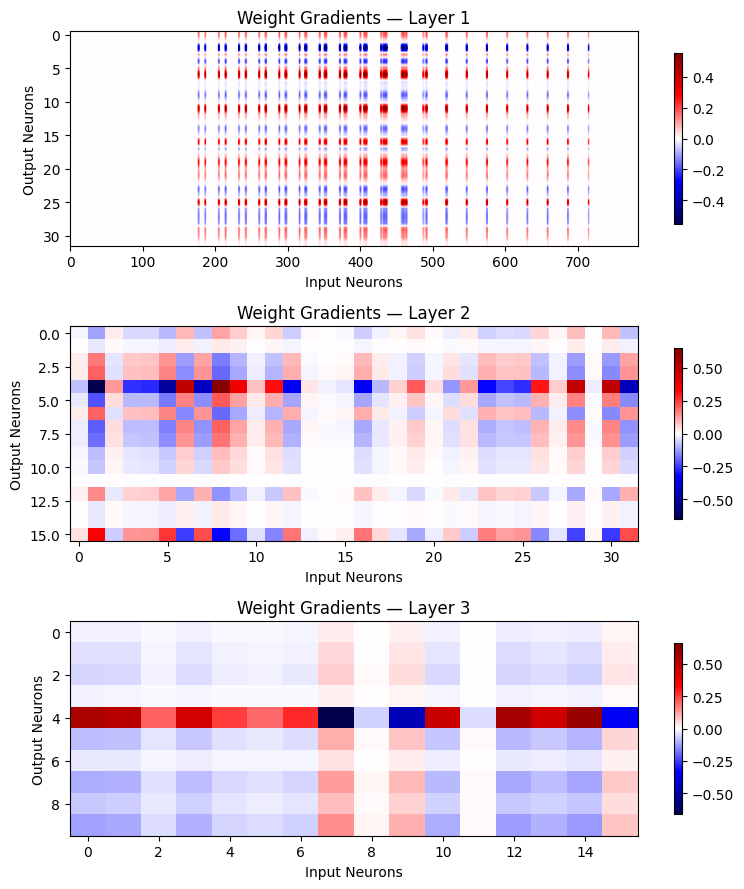


Gradient Visualization Legend:
- Each heatmap shows the weight gradients for one layer.
- Rows = output neurons, Columns = input neurons.
- Red = decrease this weight, Blue = increase this weight.
- Brighter color = stronger gradient (larger impact on loss).
- These gradients reflect how each weight would update to improve prediction for this one sample.
Gradients are visualized, but the network isn't trained yet!


In [19]:
def visualize_backward_propagation(x_sample, y_sample, weights, biases):
    """
    Arguments:
    x_sample -- numpy array of shape (input_size, 1)
    y_sample -- integer, correct class label
    weights -- list of weight matrices
    biases -- list of bias vectors
    """
    # Forward pass
    aL, cache = forward_propagation(x_sample, weights, biases)
    y_sample_batch = np.array([y_sample])

    # Backward pass
    gradients = back_propagation(y_sample_batch, cache, weights)
    delta_ws = gradients['dw']

    num_layers = len(delta_ws)

    fig, axes = plt.subplots(num_layers, 1, figsize=(8, 3 * num_layers))
    if num_layers == 1:
        axes = [axes]  # Make it iterable for single-layer case

    for idx, ax in enumerate(axes):
        grad = delta_ws[idx]
        vmax = np.max(np.abs(grad))

        im = ax.imshow(grad, aspect='auto', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.set_title(f'Weight Gradients — Layer {idx + 1}')
        ax.set_ylabel('Output Neurons')
        ax.set_xlabel('Input Neurons')
        fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8)

    plt.tight_layout()
    plt.show()

# Sample index to compute
sample_index = 42

# Initialize the weights and biases for the network
weights, biases = initialize_parameters(layer_dims)

# Verify the sample index is within bounds
assert 0 <= sample_index < y_test.shape[0], "Sample index out of range."

# Select a sample from the test setit 
x_sample = x_test[:, sample_index].reshape(-1, 1)  # Reshape the input sample to (784, 1)
y_sample = y_test[sample_index]

# Visualize backward propagation for the selected sample
visualize_backward_propagation(x_sample, y_sample, weights, biases)

# Explanation of the gradient heatmaps
print("\nGradient Visualization Legend:")
print("- Each heatmap shows the weight gradients for one layer.")
print("- Rows = output neurons, Columns = input neurons.")
print("- Red = decrease this weight, Blue = increase this weight.")
print("- Brighter color = stronger gradient (larger impact on loss).")
print("- These gradients reflect how each weight would update to improve prediction for this one sample.")

# Since the network is not yet trained, the gradients are random
print("Gradients are visualized, but the network isn't trained yet!")


## Step 5: Parameters, Predictions, and Accuracy

In this section, we'll delve into how to update the neural network's parameters, make predictions using the trained model, and evaluate the model's accuracy. Understanding these components is crucial for effectively training and assessing the performance of the neural network.

---

### 5.1 Updating Parameters

After computing the gradients during backpropagation, we need to update the weights and biases to minimize the loss function. This process is typically done using gradient descent.

Gradient Descent Formula:

$$ \theta = \theta - \alpha \cdot \nabla_{\theta}L $$

* $ \theta $: Represents the weights or biases.
* $ \alpha $ (learning rate): This is a small number (like 0.01) that controls how big a step you take in the direction of the gradient. Too big? You might overshoot. Too small? Learning will be very slow.
* $ \nabla_{\theta}L $: The gradient of the loss function with respect to $ \theta $. It tells you how much changing that parameter would affect the loss.

It can be thought of like standing on a hill (the loss function), and you're trying to walk down the hill (minimize loss). The gradient points to the steepest direction uphill, so you step in the opposite direction to go downhill the fastest.

In [20]:
def update_parameters(weights, biases, gradients, learning_rate):
    """
    Arguments:
    weights -- list of numpy arrays, each representing the weight matrix for a layer
    biases -- list of numpy arrays, each representing the bias vector for a layer
    gradients -- dictionary containing 'dw' (gradients for weights) and 'db' (gradients for biases)
    learning_rate -- float, the learning rate for gradient descent

    Returns:
    weights -- updated weights after applying gradient descent
    biases -- updated biases after applying gradient descent
    """
    
    for i in range(len(weights)):
        weights[i] -= learning_rate * gradients['dw'][i]  # Update weights
        biases[i] -= learning_rate * gradients['db'][i]  # Update biases

    return weights, biases


#### 5.1.1 Visualizing Parameter Updates

To better understand how learning happens, we can visualize the changes in the weights before and after an update. This allows us to see how the network is "learning" by adjusting its parameters based on the gradients.

In the following visualization, we will compare the weights before and after an update, as well as visualize the difference.

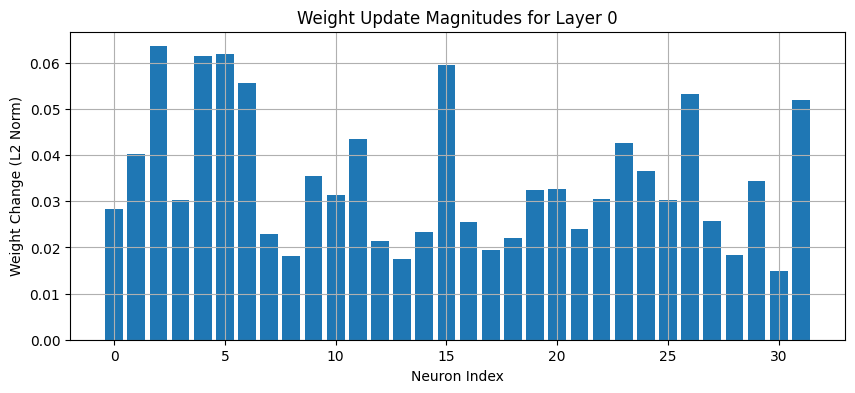

In [21]:
def visualize_parameter_updates(weights_before, weights_after, layer=0):
    """
    Arguments:
    weights_before -- list of weight matrices before the update
    weights_after -- list of weight matrices after the update
    layer -- integer, index of the layer to visualize
    """
    # Compute the weight differences
    weight_diff = weights_after[layer] - weights_before[layer]

    # Compute the L2 norm (magnitude) of updates for each output neuron (row in weight matrix)
    diff_norms = np.linalg.norm(weight_diff, axis=1)

    # Plot the weight update magnitudes
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(diff_norms)), diff_norms)
    plt.xlabel('Neuron Index')
    plt.ylabel('Weight Change (L2 Norm)')
    plt.title(f'Weight Update Magnitudes for Layer {layer}')
    plt.grid(True)
    plt.show()

# Hyperparameters for training
learning_rate = 0.1
batch_size = 64

# Clone weights before update
weights_before_update = copy.deepcopy(weights)

# Forward propagation on a batch
aL, cache = forward_propagation(x_train[:, :batch_size], weights, biases)

# Backward propagation
gradients = back_propagation(y_train[:batch_size], cache, weights)

# Update parameters
weights, biases = update_parameters(weights, biases, gradients, learning_rate)

# Visualize weight changes for the first hidden layer
visualize_parameter_updates(weights_before_update, weights, layer=0)


### 5.2 Making Predictions

Once the network is trained, we can use it to make predictions on new data.

We'll leverage the forward propagation to compute the output probabilities and then selects the class with the highest probability as the prediction.

1. Forward Propagation: Use the learned weights and biases to compute the output probabilities.
2. Argmax: For each sample, select the class with the highest probability as the predicted label.

In [22]:
def predict(x, weights, biases):
    """
    Arguments:
    x -- numpy array of shape (input_size, m), input data
    weights -- list of numpy arrays, the weight matrices for each layer
    biases -- list of numpy arrays, the bias vectors for each layer

    Returns:
    predictions -- numpy array of shape (m,), predicted labels for each input
    """
    
    # Perform forward propagation
    a2, _ = forward_propagation(x, weights, biases)

    # Take the index of the max probability for each sample
    predictions = np.argmax(a2, axis=0)

    return predictions



#### 5.2.1 Visualizing Predictions

Visualizing predictions alongside true labels helps in assessing the model's performance and identifying misclassifications.

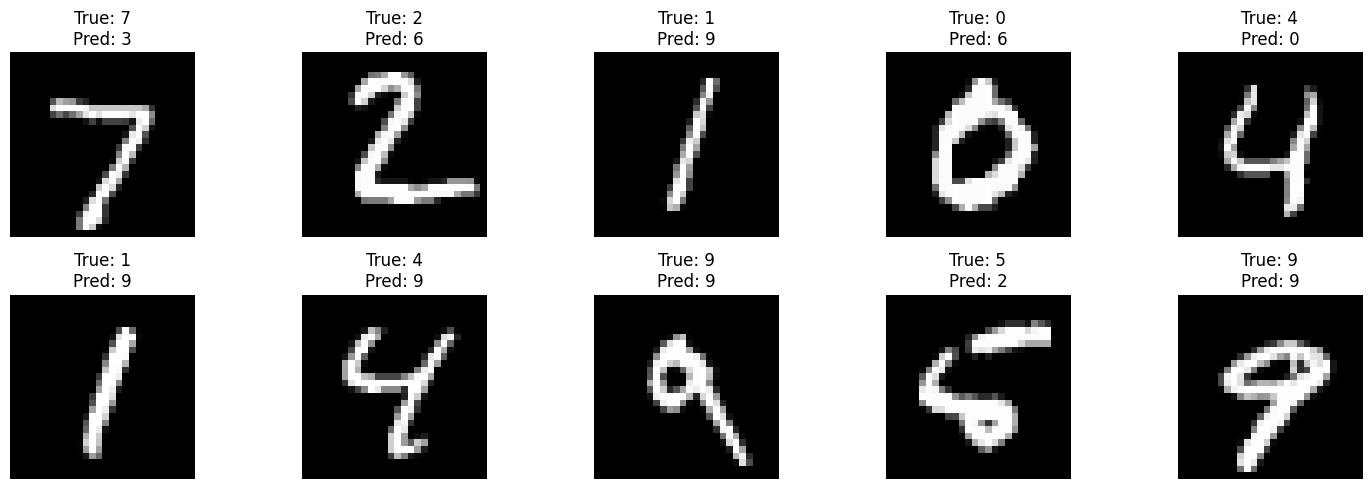

This data isn't valuable because the network isn't trained yet!


In [23]:
def visualize_predictions(x, y_true, weights, biases, num_samples=10):
    """
    Arguments:
    x -- numpy array of shape (input_size, m), input data (e.g., test images)
    y_true -- numpy array of shape (m,), true labels for the input data
    weights -- list of numpy arrays, the weight matrices for each layer
    biases -- list of numpy arrays, the bias vectors for each layer
    num_samples -- integer, number of samples to visualize
    """
    
    predictions = predict(x, weights, biases)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(x[:, i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}\nPred: {predictions[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on the first 10 test samples
x_test_subset = x_test[:, :10]
y_test_subset = y_test[:10]

visualize_predictions(x_test_subset, y_test_subset, weights, biases, num_samples=10)

print("This data isn't valuable because the network isn't trained yet!")


### 5.3 Computing Accuracy

Accuracy is a simple metric that tells us what percentage of the predictions are correct.

Accuracy Formula:

$$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} \times 100 $$

In [24]:
def compute_accuracy(y_true, y_pred):
    """
    Arguments:
    y_true -- numpy array of shape (m,), true labels
    y_pred -- numpy array of shape (m,), predicted labels

    Returns:
    accuracy -- float, accuracy as a percentage
    """
    
    return np.mean(y_true == y_pred) * 100

# Predictions on the entire test set
y_pred = predict(x_test, weights, biases)

# Compute accuracy on the test set
accuracy = compute_accuracy(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 14.24%


## Step 6: Training and Evaluating the Neural Network

In this section, we'll integrate forward propagation, backpropagation, parameter updates, and evaluation metrics to create a complete training pipeline for the neural network. By the end of this step, we'll have a functioning neural network that has been trained and evaluated.

---

### 6.1 Training the Neural Network

The goal of training is to minimize the **loss function** by updating the weights and biases in the direction that reduces the error. This process is iterative and is done over multiple **epochs** (complete passes through the dataset). Rather than passing over every single example in the dataset, we'll utilize a mini-batch (smaller sample of data) to speed up training time.

**Key Concepts:**

* Shuffling Data: The training data is shuffled at the beginning of each epoch to ensure that the model doesn't learn patterns based on the order of the data.
* Mini-Batch Gradient Descent: Instead of processing the entire dataset at once, the data is divided into smaller mini-batches to speed up training and improve generalization.
* Forward Propagation: For each mini-batch, the model computes the predicted output.
* Backpropagation: The model computes the gradients of the loss with respect to the weights and biases.
* Parameter Updates: The weights and biases are updated using gradient descent.
* Loss Tracking: The loss is recorded after each epoch to monitor the model's progress.

In [25]:
def train_neural_network(x_train, y_train, weights, biases, learning_rate, num_epochs, batch_size):
    """
    Arguments:
    x_train -- numpy array of shape (input_size, m), training input data
    y_train -- numpy array of shape (m,), true labels for training data
    weights -- list of numpy arrays, the weight matrices for each layer
    biases -- list of numpy arrays, the bias vectors for each layer
    learning_rate -- float, learning rate for gradient descent
    num_epochs -- integer, number of epochs for training
    batch_size -- integer, size of each mini-batch

    Returns:
    weights -- updated weights after training
    biases -- updated biases after training
    loss_history -- list of loss values recorded after each epoch
    accuracy_history -- list of accuracy values recorded after each epoch (if validation is provided)
    """
    
    m = x_train.shape[1]  # Number of training examples
    loss_history = []  # To track loss over epochs
    accuracy_history = []  # To track accuracy over epochs
    
    for epoch in range(1, num_epochs + 1):

        # Shuffle the training data at the start of each epoch
        permutation = np.random.permutation(m)
        x_train_shuffled = x_train[:, permutation]
        y_train_shuffled = y_train[permutation]

        # Loop over mini-batches
        for i in range(0, m, batch_size):

            x_batch = x_train_shuffled[:, i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            # Forward propagation
            aL, cache = forward_propagation(x_batch, weights, biases)

            # Backward propagation
            gradients = back_propagation(y_batch, cache, weights)

            # Update parameters
            weights, biases = update_parameters(weights, biases, gradients, learning_rate)

        # Compute loss at the end of each epoch
        aL_full, _ = forward_propagation(x_train, weights, biases)
        loss = compute_loss(aL_full, y_train)
        loss_history.append(loss)

        # Compute training accuracy at the end of each epoch
        y_pred_train = predict(x_train, weights, biases)
        accuracy = compute_accuracy(y_train, y_pred_train)
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}, Training Accuracy: {accuracy:.2f}%")

    return weights, biases, loss_history, accuracy_history



#### 6.1.1 Visualizing Training Progress

Visualizing the training progress can provide insights into how the model is learning and whether it's improving over time.

**Key Metrics:**

* Loss Curve: Shows how the cross-entropy loss decreases over epochs, indicating that the model is learning to make better predictions.
* Accuracy Calculation: Compares the predicted labels with the true labels to determine the percentage of correct predictions.

Neural Network Configuration:
------------------------------
Number of layers: 4
Layer 1 (784) -> Layer 2 (32): 
Weights shape: (32, 784), Biases shape: (32, 1)
Layer 2 (32) -> Layer 3 (16): 
Weights shape: (16, 32), Biases shape: (16, 1)
Layer 3 (16) -> Layer 4 (10): 
Weights shape: (10, 16), Biases shape: (10, 1)
Activation function: Tanh
Learning rate: 0.01
Number of epochs: 10
------------------------------
Epoch 1/10, Loss: 0.3418, Training Accuracy: 90.98%
Epoch 2/10, Loss: 0.2656, Training Accuracy: 92.60%
Epoch 3/10, Loss: 0.2190, Training Accuracy: 93.88%
Epoch 4/10, Loss: 0.1884, Training Accuracy: 94.74%
Epoch 5/10, Loss: 0.1673, Training Accuracy: 95.34%
Epoch 6/10, Loss: 0.1531, Training Accuracy: 95.75%
Epoch 7/10, Loss: 0.1371, Training Accuracy: 96.20%
Epoch 8/10, Loss: 0.1274, Training Accuracy: 96.49%
Epoch 9/10, Loss: 0.1229, Training Accuracy: 96.62%
Epoch 10/10, Loss: 0.1134, Training Accuracy: 96.84%
Training completed.


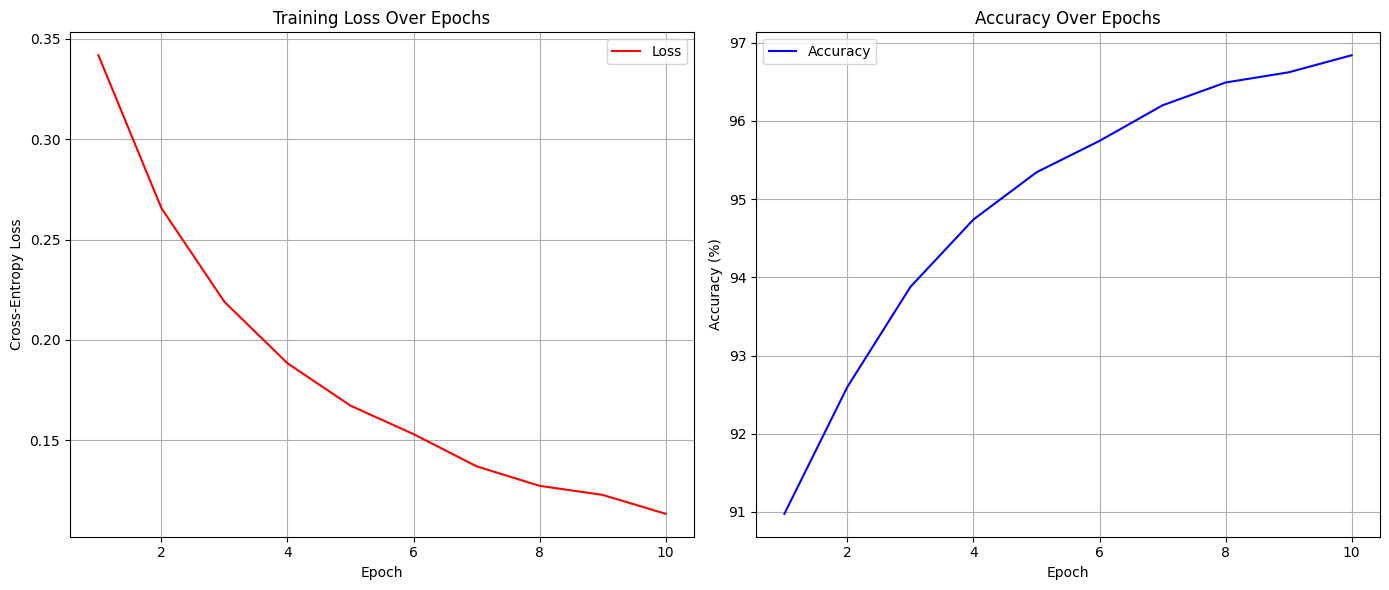

In [30]:
def plot_learning_curves(losses, accuracies):
    """
    Arguments:
    losses -- list of loss values recorded after each epoch
    accuracies -- list of accuracy values recorded after each epoch (optional)
    """
    
    epochs = range(1, len(losses) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r-', label='Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy (if available)
    if accuracies and len(accuracies) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracies, 'b-', label='Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

"""
Training The Neural Network
"""

# Initialize parameters
weights, biases = initialize_parameters(layer_dims)

# Set hyperparameters
learning_rate = 0.01
num_epochs = 10
batch_size = 16

# Print network summary
print("Neural Network Configuration:")
print("-" * 30)
print(f"Number of layers: {len(layer_dims)}")

for i in range(len(layer_dims) - 1):

    print(f"Layer {i+1} ({layer_dims[i]}) -> Layer {i+2} ({layer_dims[i+1]}): ")
    print(f"Weights shape: {weights[i].shape}, Biases shape: {biases[i].shape}")
    
print(f"Activation function: Tanh")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print("-" * 30)

# Train the model
weights, biases, loss_history, accuracy_history = train_neural_network(
    x_train, y_train, weights, biases, learning_rate, num_epochs, batch_size)

print("Training completed.")

# Plot learning curves (with validation accuracy)
plot_learning_curves(loss_history, accuracy_history)


### 6.2 Generating and Visualizing Evaluations

A confusion matrix provides a detailed breakdown of correct and incorrect predictions across all classes, offering deeper insights into the model's performance.

* Visualizing predictions shows that our neural network correctly identifies numbers unlike it used to before training.
* Visualizing a single prediction shows us how the forward propagation has changed after training.

Test Accuracy: 95.81%


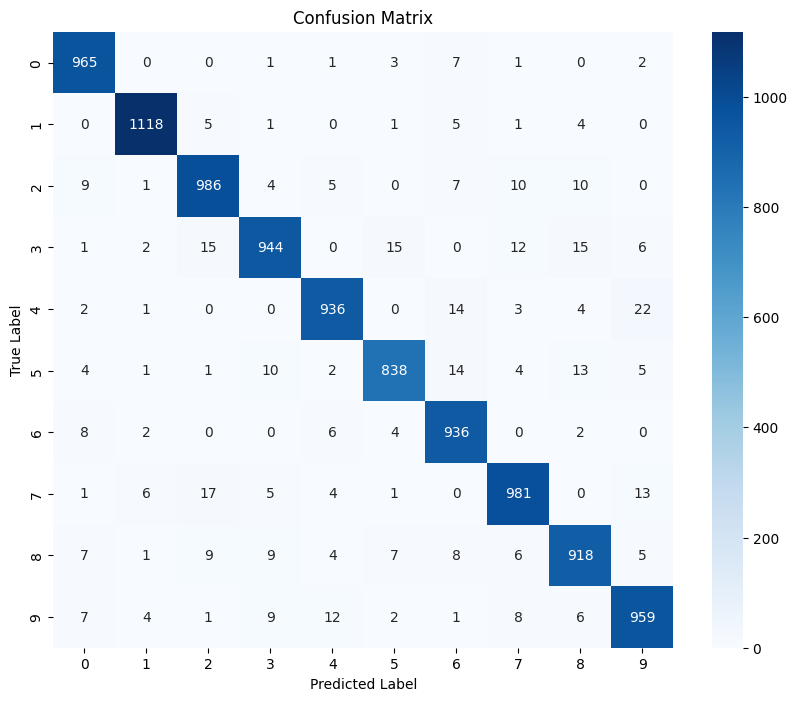

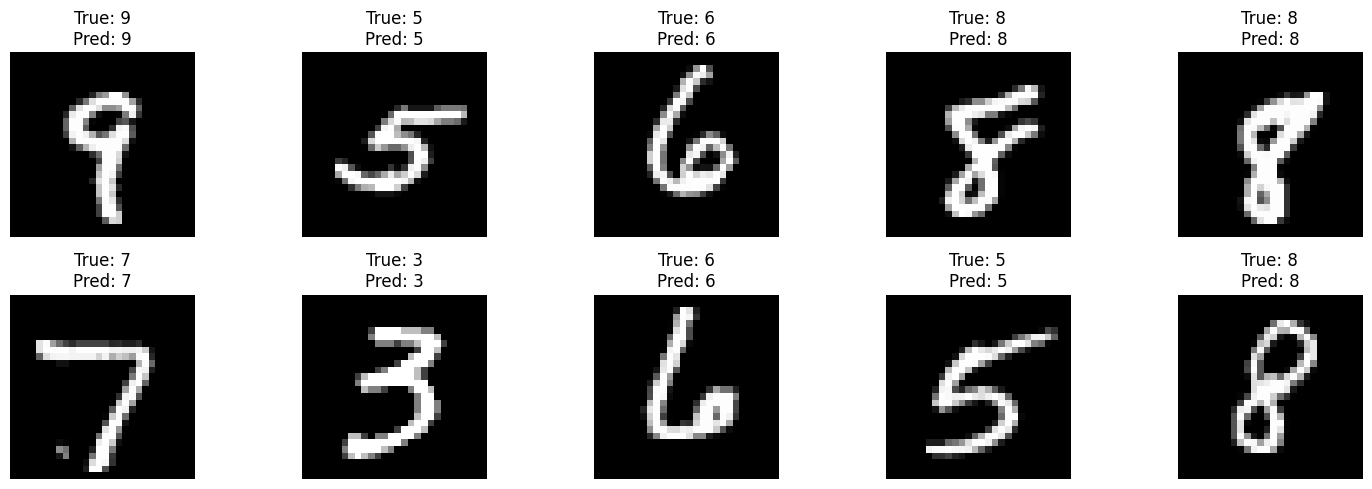

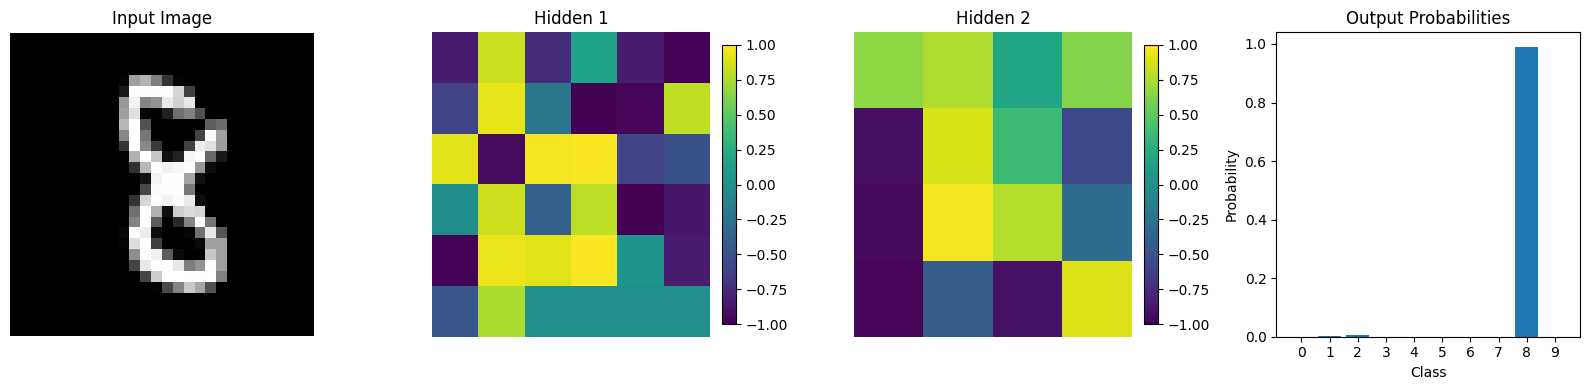

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define classes (digits 0-9)
classes = list(range(10))

# Predict labels on test set
y_pred_test = predict(x_test, weights, biases)

# Compute accuracy on the test set
test_accuracy = compute_accuracy(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot confusion matrix for the test set predictions
plot_confusion_matrix(y_test, y_pred_test, classes)

# Number of random samples to extract
num_samples = 10

# Randomly sample indices from the test set
random_indices = np.random.choice(x_test.shape[1], num_samples, replace=False)

# Extract the corresponding subset of x_test and y_test
x_test_subset = x_test[:, random_indices]
y_test_subset = y_test[random_indices]

# Visualize predictions now that the model is trained
visualize_predictions(x_test_subset, y_test_subset, weights, biases, num_samples=10)

# Randomly sample an index from the test set
random_index = np.random.choice(x_test.shape[1], 1, replace=False)

# Extract the corresponding sample
x_sample = x_test[:, random_index].reshape(-1, 1)  # Reshape to ensure it's of shape (784, 1)

# Visualize forward propagation for the random sample
visualize_forward_propagation(x_sample, weights, biases)
